## Resnet on CIFAR10

在[resnet.ipynb](./resnet.ipynb)中我们测试了Resnet在Imagenette上的分类任务, Imagenette是只包含10类的ImageNet的子集,这里我们在CIFAR10上测试对比不同的Resnet网络效果.

CIFAR-10数据集共有60000张彩色图像，这些图像是32*32，分为10个类，每类6000张图，5000张用于训练，1000张用于测试。10 个不同的类别分别代表飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.data_util.transforms import RandomResize

# 我们提前计算好了训练数据集上的均值和方差
TRAIN_MEAN = [0.49139968, 0.48215827, 0.44653124]
TRAIN_STD = [0.24703233, 0.24348505, 0.26158768]

train_dataset_transforms = transforms.Compose(
    [
        transforms.Pad(4),
        transforms.RandomRotation(3),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
# 加载数据集
train_dataset = datasets.CIFAR10(
    root=DATA_ROOT,
    train=True,
    transform=train_dataset_transforms,
    download=True,
)
val_dataset = datasets.CIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(TRAIN_MEAN, TRAIN_STD)]
    ),
    download=True,
)
print("Basic Info of train dataaset: \n", train_dataset)
print("Basic Info of test dataset: \n", val_dataset)
BATCH_SIZE = 128
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified
Basic Info of train dataaset: 
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=4, fill=0, padding_mode=constant)
               RandomRotation(degrees=[-3.0, 3.0], interpolation=nearest, expand=False, fill=0)
               RandomCrop(size=(32, 32), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
           )
Basic Info of test dataset: 
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.2434

## 测试比较不同的Resnet架构

In [3]:
from spacy import training
from hdd.models.cnn.resnet import ResnetSmall, resnet18_config
from hdd.train.early_stopping import EarlyStoppingInMem
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    resnet_config,
    train_dataloader,
    val_dataloader,
    dropout,
    lr,
    weight_decay,
    step_size=40,
    gamma=0.1,
    max_epochs=160,
) -> tuple[ResnetSmall, dict[str, list[float]]]:
    net = ResnetSmall(resnet_config, num_classes=10, dropout=dropout).to(DEVICE)
    criteria = nn.CrossEntropyLoss()
    # SGD的收敛速度远不如Adam好
    # optimizer = torch.optim.SGD(
    #     net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay
    # )
    optimizer = optim.AdamW(
        net.parameters(), lr=lr, eps=1e-6, weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=step_size, gamma=gamma, last_epoch=-1
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return net, training_stats


net, resnet18_stats = train_net(
    resnet18_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-1,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/160 Train Loss: 1.5754 Accuracy: 0.4147 Time: 6.51437  | Val Loss: 1.3648 Accuracy: 0.5173
Epoch: 2/160 Train Loss: 1.0955 Accuracy: 0.6071 Time: 5.89876  | Val Loss: 1.5117 Accuracy: 0.5157
Epoch: 3/160 Train Loss: 0.9102 Accuracy: 0.6813 Time: 6.10664  | Val Loss: 1.4193 Accuracy: 0.5716
Epoch: 4/160 Train Loss: 0.7826 Accuracy: 0.7295 Time: 5.82136  | Val Loss: 0.7988 Accuracy: 0.7389
Epoch: 5/160 Train Loss: 0.7242 Accuracy: 0.7537 Time: 5.91474  | Val Loss: 0.9694 Accuracy: 0.7021
Epoch: 6/160 Train Loss: 0.6803 Accuracy: 0.7686 Time: 5.99791  | Val Loss: 0.8352 Accuracy: 0.7249
Epoch: 7/160 Train Loss: 0.6523 Accuracy: 0.7791 Time: 5.94631  | Val Loss: 1.2362 Accuracy: 0.6403
Epoch: 8/160 Train Loss: 0.6344 Accuracy: 0.7860 Time: 5.97014  | Val Loss: 0.7764 Accuracy: 0.7465
Epoch: 9/160 Train Loss: 0.6237 Accuracy: 0.7905 Time: 6.16274  | Val Loss: 0.7315 Accuracy: 0.7629
Epoch: 10/160 Train Loss: 0.6098 Accuracy: 0.7919 Time: 5.96505  | Val Loss: 1.5264 Accuracy: 0.6276

In [4]:
from hdd.models.cnn.resnet import resnet34_config

net, resnet34_stats = train_net(
    resnet34_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-1,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/160 Train Loss: 1.5622 Accuracy: 0.4153 Time: 10.37857  | Val Loss: 1.4469 Accuracy: 0.5166
Epoch: 2/160 Train Loss: 1.1085 Accuracy: 0.6014 Time: 10.18682  | Val Loss: 1.3927 Accuracy: 0.5787
Epoch: 3/160 Train Loss: 0.8976 Accuracy: 0.6871 Time: 10.15149  | Val Loss: 1.0222 Accuracy: 0.6488
Epoch: 4/160 Train Loss: 0.7818 Accuracy: 0.7330 Time: 10.16723  | Val Loss: 0.9724 Accuracy: 0.6693
Epoch: 5/160 Train Loss: 0.7187 Accuracy: 0.7550 Time: 10.14769  | Val Loss: 1.0867 Accuracy: 0.6745
Epoch: 6/160 Train Loss: 0.6774 Accuracy: 0.7711 Time: 9.96003  | Val Loss: 0.6551 Accuracy: 0.7790
Epoch: 7/160 Train Loss: 0.6473 Accuracy: 0.7828 Time: 10.01736  | Val Loss: 0.7636 Accuracy: 0.7374
Epoch: 8/160 Train Loss: 0.6317 Accuracy: 0.7858 Time: 10.15978  | Val Loss: 0.7019 Accuracy: 0.7632
Epoch: 9/160 Train Loss: 0.6115 Accuracy: 0.7945 Time: 10.12010  | Val Loss: 0.7395 Accuracy: 0.7529
Epoch: 10/160 Train Loss: 0.6129 Accuracy: 0.7943 Time: 9.94475  | Val Loss: 0.9997 Accuracy

In [5]:
from hdd.models.cnn.resnet import resnet50_config

net, resnet50_stats = train_net(
    resnet50_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-1,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/160 Train Loss: 1.8959 Accuracy: 0.2963 Time: 20.14928  | Val Loss: 1.7417 Accuracy: 0.3973
Epoch: 2/160 Train Loss: 1.3965 Accuracy: 0.4864 Time: 20.12726  | Val Loss: 1.4714 Accuracy: 0.4988
Epoch: 3/160 Train Loss: 1.1553 Accuracy: 0.5835 Time: 20.13189  | Val Loss: 1.5966 Accuracy: 0.5040
Epoch: 4/160 Train Loss: 1.0375 Accuracy: 0.6342 Time: 20.15878  | Val Loss: 1.5955 Accuracy: 0.4909
Epoch: 5/160 Train Loss: 0.9588 Accuracy: 0.6608 Time: 20.28256  | Val Loss: 1.2455 Accuracy: 0.5747
Epoch: 6/160 Train Loss: 0.9195 Accuracy: 0.6757 Time: 20.17661  | Val Loss: 1.1823 Accuracy: 0.5929
Epoch: 7/160 Train Loss: 0.8793 Accuracy: 0.6937 Time: 20.26094  | Val Loss: 1.2263 Accuracy: 0.5791
Epoch: 8/160 Train Loss: 0.8520 Accuracy: 0.7051 Time: 20.17022  | Val Loss: 1.6649 Accuracy: 0.5131
Epoch: 9/160 Train Loss: 0.8250 Accuracy: 0.7138 Time: 20.27788  | Val Loss: 1.4251 Accuracy: 0.5784
Epoch: 10/160 Train Loss: 0.8168 Accuracy: 0.7181 Time: 20.19590  | Val Loss: 1.2131 Accura

In [6]:
from hdd.models.cnn.resnet import resnet101_config

net, resnet101_stats = train_net(
    resnet101_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-1,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/160 Train Loss: 1.9272 Accuracy: 0.2755 Time: 31.19245  | Val Loss: 1.4986 Accuracy: 0.4317
Epoch: 2/160 Train Loss: 1.4003 Accuracy: 0.4858 Time: 31.24354  | Val Loss: 1.3055 Accuracy: 0.5078
Epoch: 3/160 Train Loss: 1.1707 Accuracy: 0.5798 Time: 31.26345  | Val Loss: 1.1670 Accuracy: 0.5901
Epoch: 4/160 Train Loss: 1.0435 Accuracy: 0.6295 Time: 31.25911  | Val Loss: 0.9785 Accuracy: 0.6599
Epoch: 5/160 Train Loss: 0.9744 Accuracy: 0.6535 Time: 31.26375  | Val Loss: 1.2549 Accuracy: 0.5797
Epoch: 6/160 Train Loss: 0.9295 Accuracy: 0.6736 Time: 31.24137  | Val Loss: 1.1797 Accuracy: 0.5941
Epoch: 7/160 Train Loss: 0.8956 Accuracy: 0.6846 Time: 31.22354  | Val Loss: 1.3562 Accuracy: 0.5508
Epoch: 8/160 Train Loss: 0.8646 Accuracy: 0.7005 Time: 31.25130  | Val Loss: 1.0283 Accuracy: 0.6473
Epoch: 9/160 Train Loss: 0.8432 Accuracy: 0.7072 Time: 31.23822  | Val Loss: 1.3356 Accuracy: 0.5657
Epoch: 10/160 Train Loss: 0.8173 Accuracy: 0.7208 Time: 31.23483  | Val Loss: 1.5366 Accura

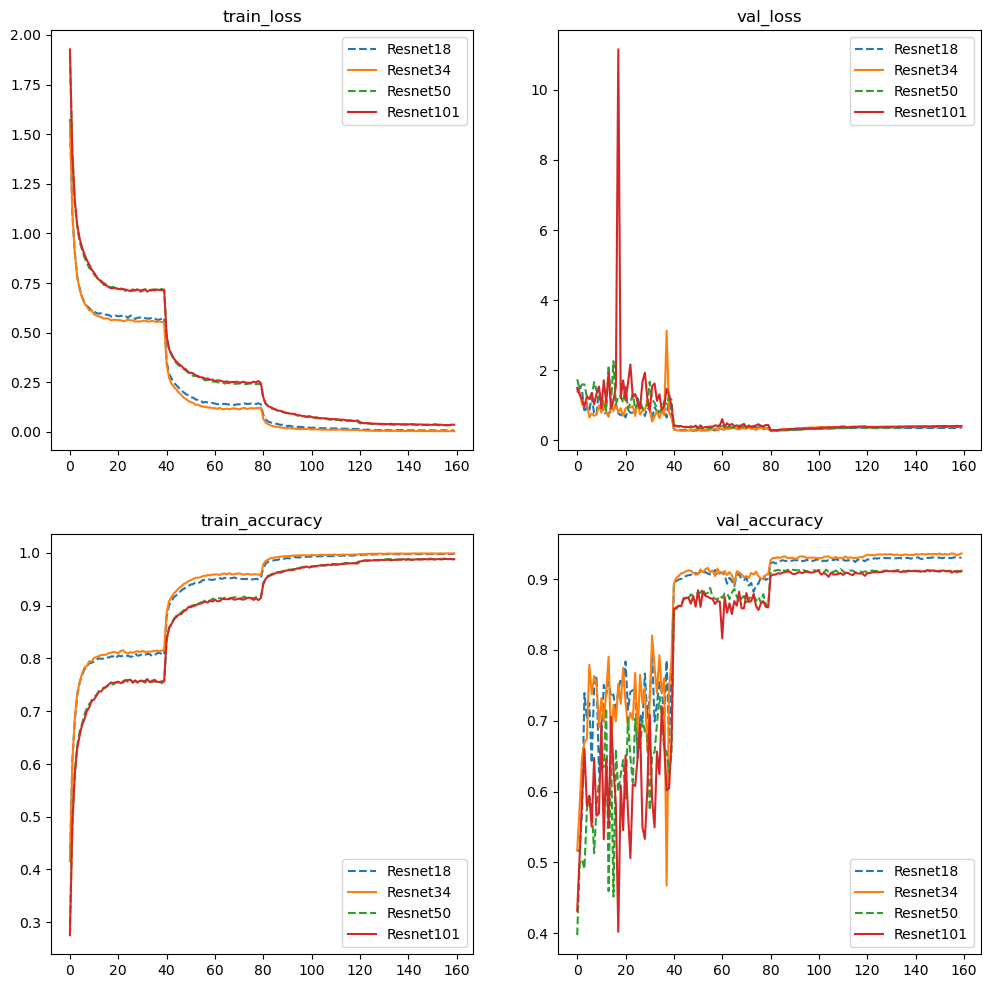

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = resnet18_stats.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(resnet18_stats[field], label="Resnet18", linestyle="--")
    plt.plot(resnet34_stats[field], label="Resnet34")
    plt.plot(resnet50_stats[field], label="Resnet50", linestyle="--")
    plt.plot(resnet101_stats[field], label="Resnet101", linestyle="-")
    plt.legend()
    plt.title(field)